<a href="https://colab.research.google.com/github/faisal-rasheed-lone/Neural-Networks-And-Deep-Learning/blob/master/Multi_class_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-11-12 05:36:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  20.8MB/s    in 24s     

2023-11-12 05:37:19 (20.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [2]:
import os

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 

In [3]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [4]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [5]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


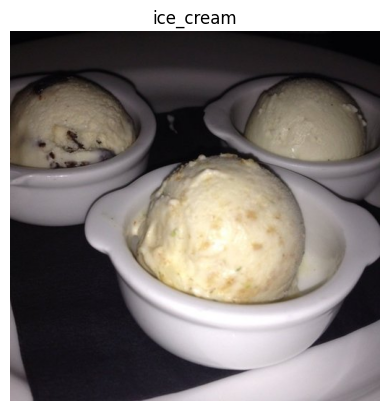

In [6]:
# View a random image from the training dataset

img = view_random_image(target_dir=train_dir,target_class=random.choice(class_names)) # get a random class name

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [8]:
# Define a random seed for reproducibility
seed = 42

# Rescale the data and create data generator instances with augmentations
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,           # Randomly apply shear transformations
    zoom_range=0.2,            # Randomly zoom in by up to 20%
    # horizontal_flip=True,      # Randomly flip images horizontally
    # fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1/255.)  # Only rescale for the test data

# Load data from directories and turn it into batches with seed settings
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # For multiclass classification
    seed=seed  # Set seed for reproducibility
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # For multiclass classification
    seed=seed  # Set seed for reproducibility
)


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [14]:
num_classes = 10
# Define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation = 'relu' ))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(num_classes, activation='softmax'))  # num_classes is the number of classes in your dataset


In [15]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 conv2d_22 (Conv2D)          (None, 107, 107, 64)      36928     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 53, 53, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 51, 51, 128)      

In [17]:
# Adding Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model1.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=7,
#     verbose=1
# )

In [18]:
# Fit the model
history = model.fit(train_data, # now 10 different classes
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/100
235/235 [==============================] - 146s 558ms/step - loss: 2.1711 - accuracy: 0.2027 - val_loss: 2.0037 - val_accuracy: 0.3008
Epoch 2/100
235/235 [==============================] - 124s 526ms/step - loss: 2.0265 - accuracy: 0.2857 - val_loss: 1.8619 - val_accuracy: 0.3516
Epoch 3/100
235/235 [==============================] - 126s 537ms/step - loss: 1.9658 - accuracy: 0.3157 - val_loss: 1.8311 - val_accuracy: 0.3724
Epoch 4/100
235/235 [==============================] - 125s 533ms/step - loss: 1.9099 - accuracy: 0.3420 - val_loss: 1.7476 - val_accuracy: 0.4136
Epoch 5/100
235/235 [==============================] - 124s 527ms/step - loss: 1.8677 - accuracy: 0.3461 - val_loss: 1.7846 - val_accuracy: 0.3968
Epoch 6/100
235/235 [==============================] - 127s 537ms/step - loss: 1.8376 - accuracy: 0.3651 - val_loss: 1.7968 - val_accuracy: 0.3936
Epoch 7/100
235/235 [==============================] - 128s 544ms/step - loss: 1.8070 - accuracy: 0.3833 - val_loss: 1

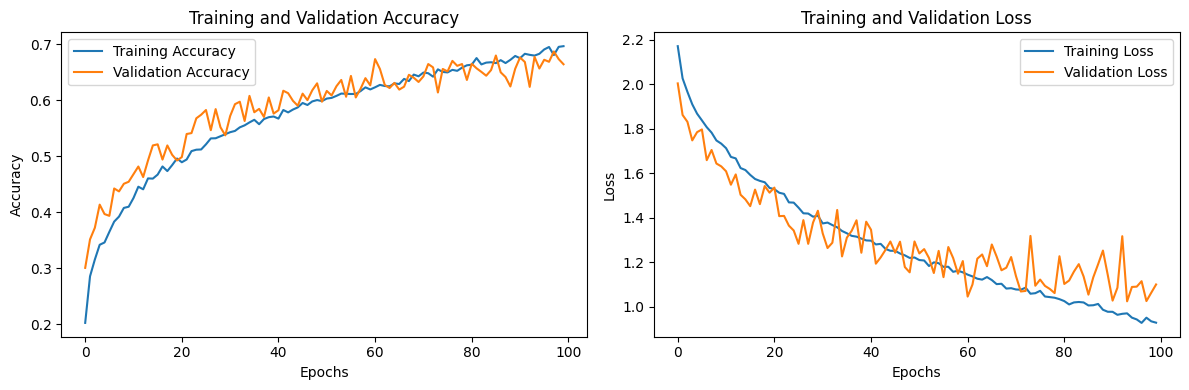

In [21]:

import matplotlib.pyplot as plt

# Get the training history
history_dict = history.history

# Plot training and validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img


In [23]:
class_names = ['chicken_curry','chicken_wings','fried_rice','grilled_salmon','hamburger','ice_cream','pizza','ramen','steak','sushi']


In [24]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [25]:
# -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

1/1 [==============================] - 1s 860ms/step


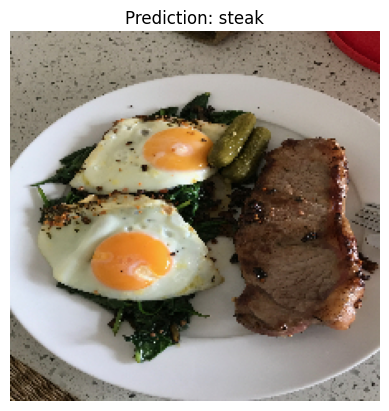

In [26]:
pred_and_plot(model, "03-steak.jpeg", class_names)